In [1]:
!nvidia-smi

Wed Jun  9 14:47:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os, shutil
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [4]:
import cv2
from keras.preprocessing.image import ImageDataGenerator

## Added more data (generated mask images to counter the incorrect mask images wrong prediction problem)

# Preprocessing images

In [5]:
image_gen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dir = '/content/grive/MyDrive/Face Mask Dataset/Train'
val_dir = '/content/grive/MyDrive/Face Mask Dataset/Validation'
test_dir = '/content/grive/MyDrive/Face Mask Dataset/Test'

In [7]:
batch_size = 80
train_generator = image_gen.flow_from_directory(train_dir,
                                          target_size=(150,150),
                                          batch_size=batch_size,
                                          seed=42,
                                          shuffle=False,
                                          class_mode='categorical')
val_generator = image_gen.flow_from_directory(val_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=False,
                                        class_mode='categorical')
test_generator = image_gen.flow_from_directory(test_dir,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        seed=42,
                                        shuffle=False,
                                        class_mode='categorical')

Found 24010 images belonging to 3 classes.
Found 2700 images belonging to 3 classes.
Found 2700 images belonging to 3 classes.


# Building CNN Model

In [8]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint


In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
result = model.fit_generator(train_generator, 
                             validation_data=val_generator,
                             epochs=30,
                             steps_per_epoch=(len(train_generator.labels)/80),
                             validation_steps=(len(val_generator.labels)/80)
                             )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
300/300 [==============================] - 8764s 29s/step - loss: 1.2105 - accuracy: 0.3269 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 2/30
300/300 [==============================] - 236s 787ms/step - loss: 1.1007 - accuracy: 0.3073 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/30
300/300 [==============================] - 233s 778ms/step - loss: 1.1027 - accuracy: 0.3840 - val_loss: 1.3095 - val_accuracy: 0.3333
Epoch 4/30
300/300 [==============================] - 231s 767ms/step - loss: 1.1358 - accuracy: 0.3843 - val_loss: 1.0995 - val_accuracy: 0.3374
Epoch 5/30
300/300 [==============================] - 229s 764ms/step - loss: 1.1553 - accuracy: 0.3521 - val_loss: 0.9256 - val_accuracy: 0.6419
Epoch 6/30
300/300 [==============================] - 231s 769ms/step - loss: 0.9948 - accuracy: 0.6140 - val_loss: 0.2809 - val_accuracy: 0.9026
Epoch 7/30
300/300 [==============================] - 233s 777ms/step - loss: 0.2807 - accuracy: 0.8980 - val_loss: 0.1419 - 

In [12]:
model.save('multiclass_baseline.h5')

# Evaluation on model

In [13]:
result.history['accuracy']

[0.35122865438461304,
 0.3036651313304901,
 0.32827988266944885,
 0.40399834513664246,
 0.3804664611816406,
 0.626405656337738,
 0.9147855043411255,
 0.9528529644012451,
 0.959933340549469,
 0.9586422443389893,
 0.9736359715461731,
 0.9801332950592041,
 0.9850062727928162,
 0.9866305589675903,
 0.9881715774536133,
 0.9868388175964355,
 0.9916701316833496,
 0.9933777451515198,
 0.9930445551872253,
 0.9934194087982178,
 0.996001660823822,
 0.9961265921592712,
 0.9458975195884705,
 0.9913369417190552,
 0.9977092742919922,
 0.9970012307167053,
 0.997584342956543,
 0.9995834827423096,
 0.9997500777244568,
 1.0]

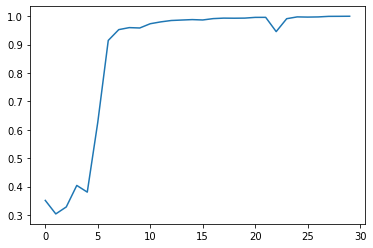

In [14]:
plt.plot(result.history['accuracy'])

In [15]:
result.history['val_accuracy']

[0.3333333432674408,
 0.3333333432674408,
 0.3333333432674408,
 0.3374074101448059,
 0.6418518424034119,
 0.9025925993919373,
 0.9548147916793823,
 0.9685184955596924,
 0.978518545627594,
 0.9651851654052734,
 0.978518545627594,
 0.979629635810852,
 0.9859259128570557,
 0.9907407164573669,
 0.9833333492279053,
 0.9914814829826355,
 0.9933333396911621,
 0.9933333396911621,
 0.9925925731658936,
 0.9907407164573669,
 0.9948148131370544,
 0.9833333492279053,
 0.9892592430114746,
 0.9937037229537964,
 0.9948148131370544,
 0.9900000095367432,
 0.9951851963996887,
 0.9974074363708496,
 0.996666669845581,
 0.9959259033203125]

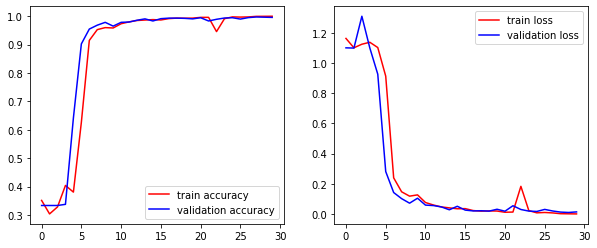

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(result.history['accuracy'], label='train accuracy', color='red')
plt.plot(result.history['val_accuracy'], label='validation accuracy', color='blue')
plt.legend()

plt.subplot(1,2,2)
plt.plot(result.history['loss'], label='train loss', color='red')
plt.plot(result.history['val_loss'], label='validation loss', color='blue')
plt.legend()

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
prediction = model.predict_classes(test_generator)
y_true = test_generator.labels

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [19]:
train_generator.class_indices

{'IncorrectMask': 0, 'WithMask': 1, 'WithoutMask': 2}

In [20]:
confusion_matrix(y_true, prediction)

array([[898,   2,   0],
       [  1, 891,   8],
       [  0,   6, 894]])

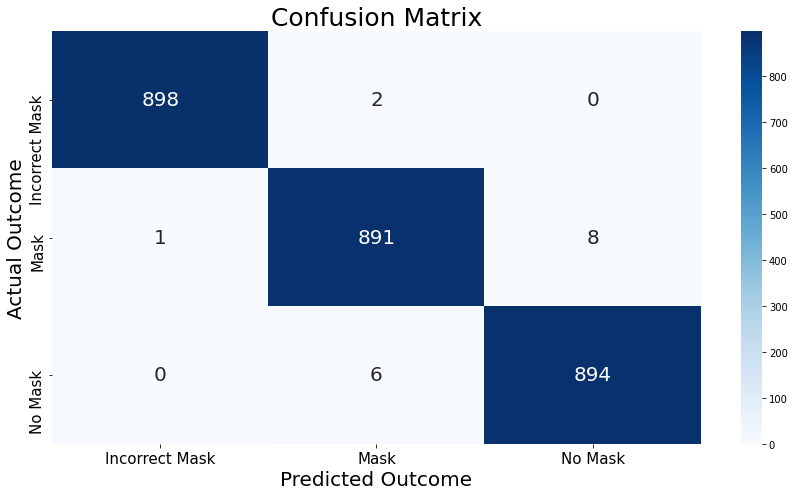

In [21]:
plt.figure(figsize=(35,7))
plt.subplot(131)
ax = sns.heatmap(confusion_matrix(test_generator.labels, prediction.round()),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")
# cmlabels = ['True Negatives', "False Positives",
#                'Flase Negatives', "True Positives"]
# for i,t in enumerate(ax.texts):
#   t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = ['Incorrect Mask', 'Mask', 'No Mask']
ax.set_xticklabels(labels, size=15)
ax.set_yticklabels(labels, size=15)
plt.tight_layout()
plt.show();

In [22]:
print(classification_report(y_true, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       900
           1       0.99      0.99      0.99       900
           2       0.99      0.99      0.99       900

    accuracy                           0.99      2700
   macro avg       0.99      0.99      0.99      2700
weighted avg       0.99      0.99      0.99      2700



In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, prediction)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_true, prediction, average="macro")
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_true, prediction, average="macro")
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, prediction, average="macro")
print('F1 score: %f' % f1)

Accuracy: 0.993704
Precision: 0.993707
Recall: 0.993704
F1 score: 0.993705


In [24]:
model.save('/content/grive/MyDrive/multiclass_baseline.h5')